# Importing

In [4]:
# Required Libraries installation
!pip install pyspark
!pip install pandas scikit-learn nltk pygal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Importing Libraries
from google.colab import drive
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when,round,month,datediff, to_date
import math
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.window import Window
from functools import reduce
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pygal
import nltk
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, StructType, StructField
from pyspark.sql.types import IntegerType
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading DataSet

In [7]:
# Create a SparkSession
spark = SparkSession.builder.master("local[4]").appName("ClusterShop").getOrCreate()

# set log level to Error
spark.sparkContext.setLogLevel("ERROR")


In [8]:
# Read the Excel file using Pandas
df_pandas = pd.read_excel("drive/MyDrive/Online Retail.xlsx",na_values='')

# Convert the Pandas DataFrame to PySpark DataFrame 
df_spark = spark.createDataFrame(df_pandas)

# EDA

In [9]:
# helper functions
def show_df(df, n=5):
  return df.show(n)

def df_stats(df):
  return df.describe().show()



def percent_missing(df):
  # get columns excluding 'InvoiceDate'
  cols = [col for col in df.columns if col != 'InvoiceDate']


  # count missing values in each column as a percentage of the total number of values and total number of values in each column
  df.select([count(when(~isnan(c), c)).alias(c) for c in cols]).show()
  df.select([count(when(isnan(c), c)).alias(c) for c in cols]).show()

def values_distribution(df,col,bins=100,xlim=10000,xlabel='TotalCost',ylabel='Frequency',title='Distribution of basket prices'):

  # convert the PySpark DataFrame to Pandas DataFrame
  df_pd = df.toPandas()

  # plot the histogram
  fig, ax = plt.subplots()
  ax.hist(df_pd[col], bins=bins)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  plt.rc('xtick', labelsize=10)
  plt.rc('ytick', labelsize=10)
  ax = plt.gca()
  ax.set_xlim([0,xlim])
  plt.show()

In [10]:
percent_missing(df_spark)

+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|   541909|   541909|     540455|  541909|   541909|    406829| 541909|
+---------+---------+-----------+--------+---------+----------+-------+

+---------+---------+-----------+--------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+---------+----------+-------+
|        0|        0|       1454|       0|        0|    135080|      0|
+---------+---------+-----------+--------+---------+----------+-------+



In [57]:
spark

In [58]:
df_spark.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [59]:
df_spark.show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows



In [11]:
# filter out the missing values using map 
df_spark_filtered = df_spark.rdd.map(lambda x: x if not math.isnan(x['CustomerID'])  else None).filter(lambda x: x is not None).toDF()

In [60]:
number_befoe_removing_duplicates = df_spark_filtered.count()
#I want to remove duplicates while perserving the original order of the rows
df_spark_filtered = df_spark_filtered.dropDuplicates()
df_spark_filtered= df_spark_filtered.orderBy('InvoiceNo', 'InvoiceDate')
number_after_removing_duplicates = df_spark_filtered.count()
print(f"Number of duplicates: {number_befoe_removing_duplicates - number_after_removing_duplicates}")

Number of duplicates: 5226


In [13]:
original_cols = df_spark.columns

### InvoiceNo
* uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* 6-digit integral number

In [12]:
# get percentage of cancelled invoices using map reduce in spark rdd
unique_invoice = df_spark_filtered.select('InvoiceNo').distinct().count()
cancelled_invoice_count = df_spark_filtered.select('InvoiceNo').rdd.map(lambda x: x if x.InvoiceNo.startswith('C') else None).filter(lambda x: x is not None).toDF()

cancelled_invoice_count = cancelled_invoice_count.select('InvoiceNo').distinct().count()


# percentage of cancelled invoices
print("Percentage of cancelled invoices: ", (cancelled_invoice_count/unique_invoice)*100)

Percentage of cancelled invoices:  16.466876971608833


In [61]:
df_sorted_CustomerID = df_spark_filtered.sort('CustomerID')
df_sorted_CustomerID.show(5)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-------------+------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|FirstPurchase|LastPurchase|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-------------+------------+
|   541431|    23166|MEDIUM CERAMIC TO...|   74215| 2011-01-18|     1.04|   12346.0|United Kingdom|   2011-01-18|  2011-01-18|
|  C541433|    23166|MEDIUM CERAMIC TO...|  -74215| 2011-01-18|     1.04|   12346.0|United Kingdom|   2011-01-18|  2011-01-18|
|   537626|    20782|CAMOUFLAGE EAR MU...|       6| 2010-12-07|     5.49|   12347.0|       Iceland|   2010-12-07|  2010-12-07|
|   537626|    84969|BOX OF 6 ASSORTED...|       6| 2010-12-07|     4.25|   12347.0|       Iceland|   2010-12-07|  2010-12-07|
|   542237|    21035|SET/2 RED RETROSP...|       6| 2011-01-26|     2.95|   12347.0|       Iceland|   2010-12-0

* Look at the first two transactions are the same(StockCode,Description,UnitPrice,CustomerID,Country)
* and different(InvoiceNo,sign of Quantity,InvoiceDate)
* which means the second transaction is a cancellation of the first one

* try to check if every negative quantity transaction (cancellation) has a positive quantity transaction in our data

In [62]:
from pyspark.sql.functions import col

df_check = df_spark_filtered.filter(col('Quantity') < 0).select('CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice')
for row in df_check.rdd.collect():
    if df_spark_filtered.filter((col('CustomerID') == row[0]) & (col('Quantity') == -row[1]) & (col('Description') == row[2])).count() == 0:
        print(row)
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

Row(CustomerID=14527.0, Quantity=-1, StockCode='D', Description='Discount', UnitPrice=27.5)
---------------> HYPOTHESIS NOT FULFILLED


* we will discard the Discount transactions

In [63]:
from pyspark.sql.functions import col

df_check = df_spark_filtered.filter((col('Quantity') < 0) & (col('Description')!='Discount')).select('CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice')
for row in df_check.rdd.collect():
    if df_spark_filtered.filter((col('CustomerID') == row[0]) & (col('Quantity') == -row[1]) & (col('Description') == row[2])).count() == 0:
        print(row)
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

Row(CustomerID=15311.0, Quantity=-1, StockCode='35004C', Description='SET OF 3 COLOURED  FLYING DUCKS', UnitPrice=4.65)
---------------> HYPOTHESIS NOT FULFILLED


* Then not every negative quantity transaction (cancellation) has a positive quantity transaction in our data
* May be its positive pair was before the starting date of our data or removed by the data cleaning process (having null CustomerID)

### StockCode
* uniquely assigned to each distinct product
* 5-digit integral number

In [64]:
number_of_unique_products = df_spark_filtered.select('StockCode').distinct().count()
print(f"Number of unique products: {number_of_unique_products}")

Number of unique products: 3680


In [65]:
#get stockCodes that are not numbers
from pyspark.sql.functions import regexp_extract, col
list_special_codes = df_spark_filtered.select(['StockCode','Description']).filter(col('StockCode').rlike('^[a-zA-Z]+'))
list_special_codes.distinct().show()

+------------+--------------------+
|   StockCode|         Description|
+------------+--------------------+
|        POST|             POSTAGE|
|         DOT|      DOTCOM POSTAGE|
|           D|            Discount|
|          C2|            CARRIAGE|
|BANK CHARGES|        Bank Charges|
|        PADS|PADS TO MATCH ALL...|
|           M|              Manual|
|        CRUK|     CRUK Commission|
+------------+--------------------+



In [66]:
#most popular items ==for every StockCode count the sum of the Quantity in all the invoices and return the top 5
from pyspark.sql.functions import sum
df_spark_filtered.groupBy('StockCode').agg(sum('Quantity').alias('Quantity')).orderBy('Quantity', ascending=False).show(5)

+---------+--------+
|StockCode|Quantity|
+---------+--------+
|    84077|   53119|
|    22197|   48689|
|   85099B|   44963|
|    84879|   35215|
|   85123A|   34186|
+---------+--------+
only showing top 5 rows



### Description
Product (item) name. Nominal.

In [67]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, StructType, StructField

is_noun = lambda pos: pos[:2] == 'NN'
# Define a user-defined function (UDF) to extract nouns from a sentence
def extract_nouns(sentence):
    if sentence is None:
        return []
    else:
        stemmer = nltk.stem.SnowballStemmer("english")
        tokenized = nltk.word_tokenize(sentence.lower())
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
     

        return [stemmer.stem(noun) for noun in nouns]

# Register the UDF with PySpark SQL
extract_nouns_udf = udf(extract_nouns, ArrayType(StringType()))

# Define the schema for the output of the keywords_inventory function
keywords_schema = StructType([
    StructField("category_key", StringType(), True),
    StructField("keywords_roots", StringType(), True),
    StructField("keywords_select", StringType(), True),
    StructField("count_keywords", StringType(), True)
])

def keywords_inventory(dataframe, colonne='Description'):
    # Apply the extract_nouns UDF to the specified column and create a new column with the extracted nouns
    dataframe = dataframe.withColumn("nouns", extract_nouns_udf(dataframe[colonne]))
    
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys = []
    count_keywords = dict()
    
    for row in dataframe.select("nouns").collect():
        nouns = row[0]
        
        for t in nouns:
            racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
    
    # Convert the results to PySpark DataFrame and return
    result = [[category_keys[i], list(keywords_roots.keys())[i], keywords_select[list(keywords_roots.keys())[i]], count_keywords[list(keywords_roots.keys())[i]]] for i in range(len(category_keys))]
    return spark.createDataFrame(result, schema=keywords_schema)


# get unique products describtions
df_products_desc = df_spark_filtered.select('Description').distinct()

# Apply the keywords_inventory function to the dataframe
keywords = keywords_inventory(df_products_desc)

# Display the number of keywords
print("Number of keywords: ", keywords.count())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Number of keywords:  1481


+------------+--------------+---------------+--------------+
|category_key|keywords_roots|keywords_select|count_keywords|
+------------+--------------+---------------+--------------+
|       heart|         heart|          heart|           267|
|      vintag|        vintag|         vintag|           211|
|         set|           set|            set|           206|
|        pink|          pink|           pink|           188|
|         bag|           bag|            bag|           165|
|         box|           box|            box|           154|
|       glass|         glass|          glass|           148|
|    christma|      christma|       christma|           137|
|      design|        design|         design|           128|
|       candl|         candl|          candl|           121|
|      flower|        flower|         flower|           120|
|      holder|        holder|         holder|           119|
|       decor|         decor|          decor|           109|
|       metal|         m

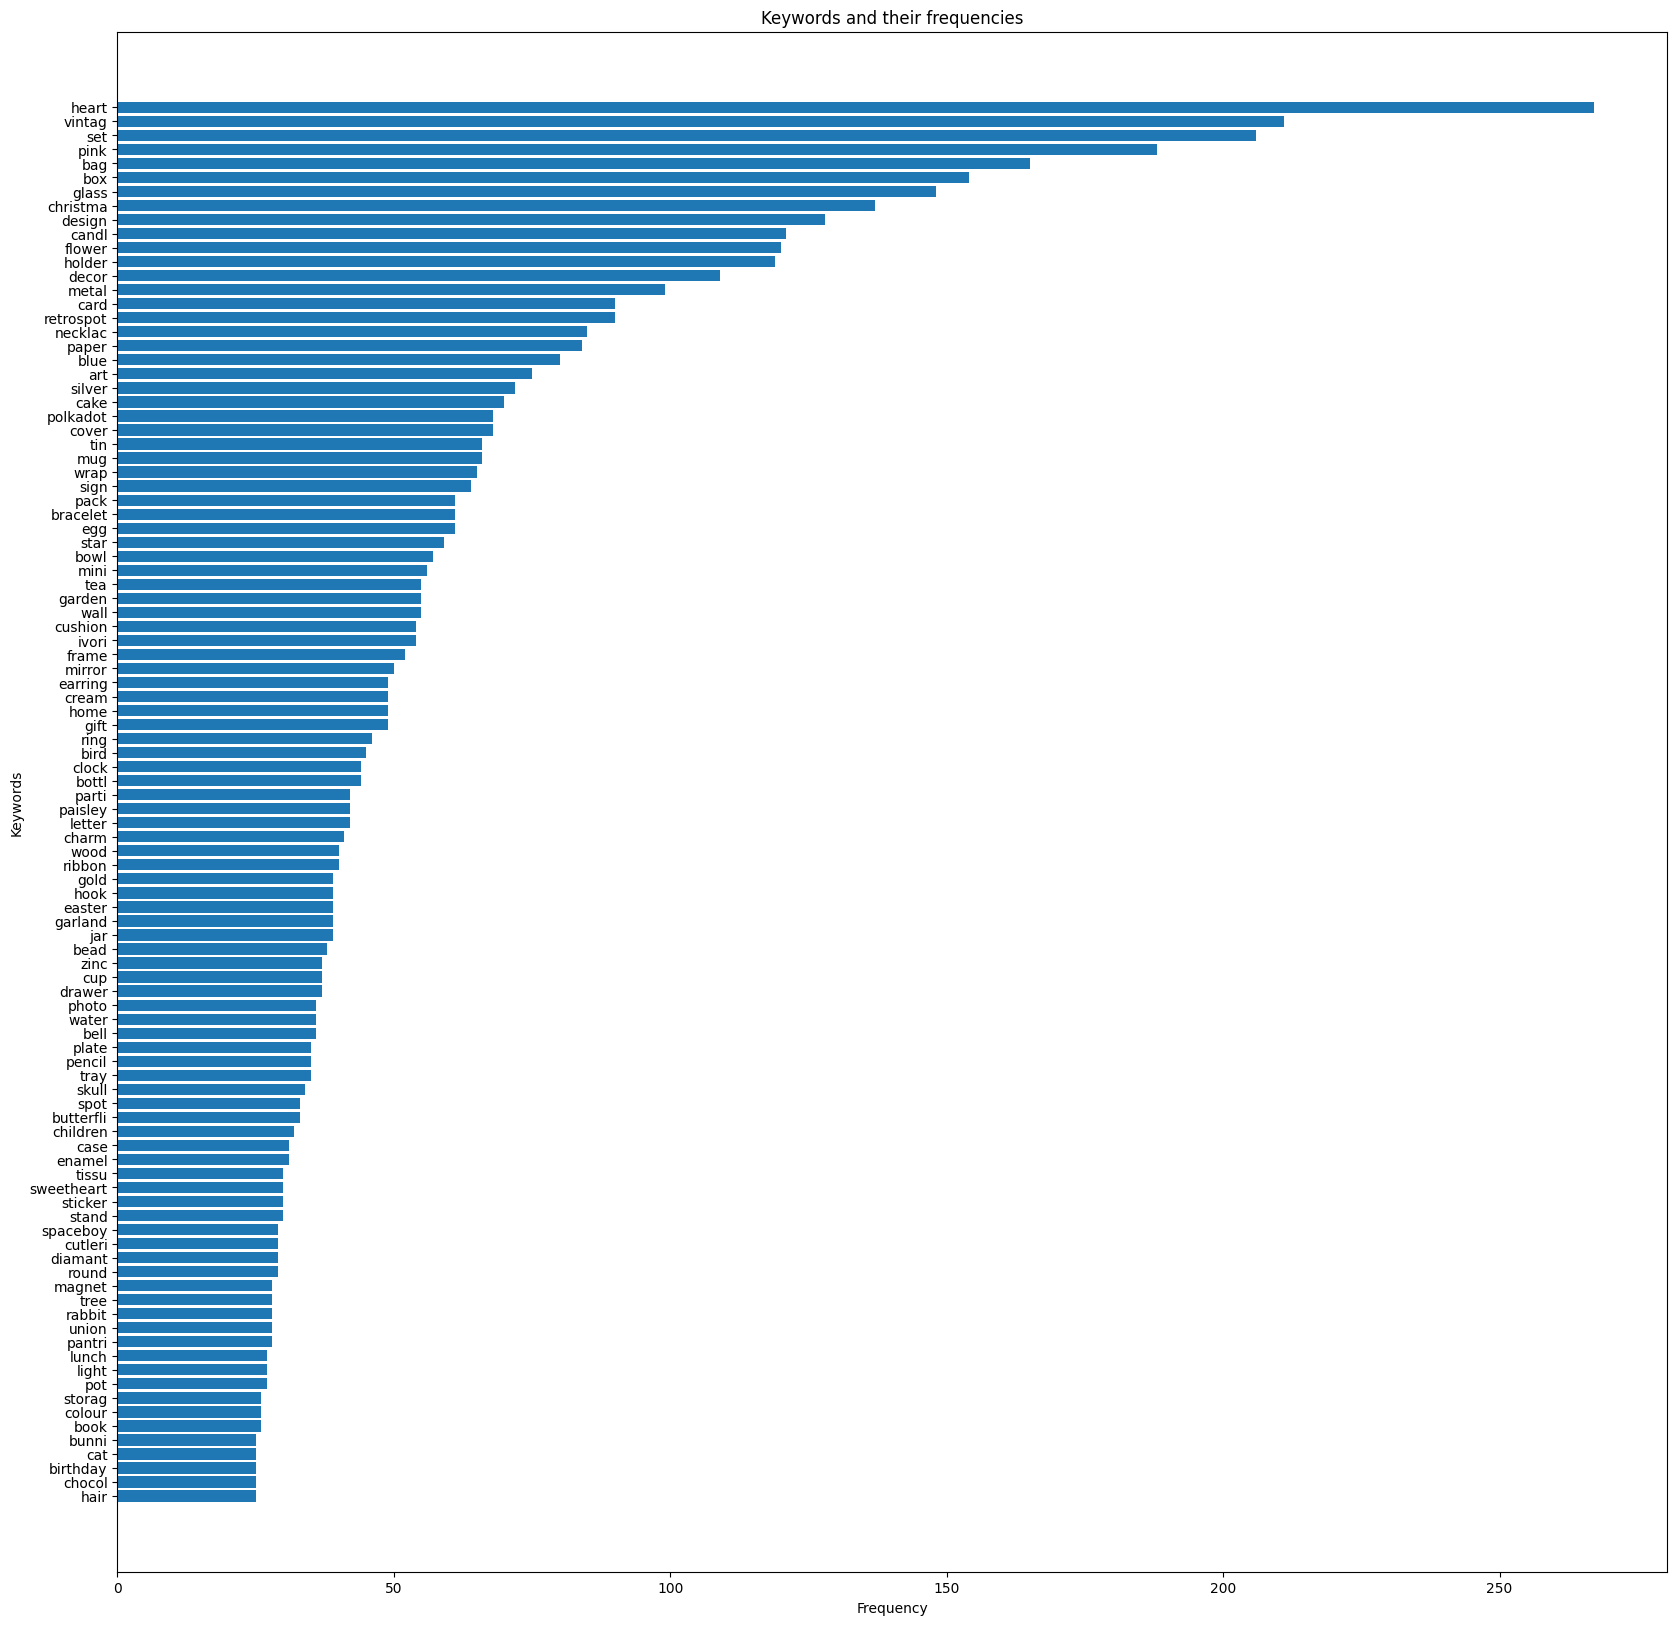

In [68]:
# sort the keywords by their frequencies after converting the count_keywords column to integer  
keywords = keywords.withColumn("count_keywords", keywords["count_keywords"].cast("int")).sort("count_keywords", ascending=False)
keywords.show()

# plot the histogram of the keywords frequencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# convert the PySpark DataFrame to Pandas DataFrame
keywords_pd = keywords.toPandas()

# plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(20, 20))
ax.barh(keywords_pd['category_key'][:100], keywords_pd['count_keywords'][:100])
ax.set_xlabel('Frequency')
ax.set_ylabel('Keywords')
ax.set_title('Keywords and their frequencies')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax = plt.gca()
ax.invert_yaxis()
plt.show()

In [90]:
# consider only the keywords with frequency greater than 15
keywords_filtered = keywords.filter(keywords['count_keywords'] > 15)

print("Number of keywords: ", keywords_filtered.count())

Number of keywords:  161


In [69]:
count_keywords = keywords_pd['count_keywords'].values.tolist()
keywords_select = keywords_pd['category_key'].values.tolist()

count_keywords = dict(enumerate(count_keywords))
keywords_select = dict(enumerate(keywords_select))

list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print("Number of products: ", len(list_products))

Number of products:  193


### Quantity
The quantities of each product (item) per transaction. Numeric.


In [70]:
df_spark_filtered.select('Quantity').describe().show()

+-------+------------------+
|summary|          Quantity|
+-------+------------------+
|  count|            401205|
|   mean|12.199277177502774|
| stddev| 250.4056845915837|
|    min|            -80995|
|    max|             80995|
+-------+------------------+



### CustomerID
*  a 5-digit integral number uniquely assigned to each customer

In [71]:
#get number of unique customers
df_spark_filtered.select('CustomerID').distinct().count()

4330

In [72]:
# group by CustomerID, InvoiceNo, and count the number of rows
from pyspark.sql.functions import count
temp = df_spark_filtered.groupBy('CustomerID', 'InvoiceNo').agg(count('Quantity').alias('Number of products')).orderBy('CustomerID', ascending=True)
temp.show(10)

+----------+---------+------------------+
|CustomerID|InvoiceNo|Number of products|
+----------+---------+------------------+
|   12346.0|  C541433|                 1|
|   12346.0|   541431|                 1|
|   12347.0|   537626|                31|
|   12347.0|   542237|                29|
|   12347.0|   581180|                11|
|   12347.0|   562032|                22|
|   12347.0|   556201|                18|
|   12347.0|   573511|                47|
|   12347.0|   549222|                24|
|   12348.0|   548955|                 5|
+----------+---------+------------------+
only showing top 10 rows



* Invoices starts whit C are cancelled
* there are customers only buy small quantities of products and other customers buy large quantities of products

### InvoiceDate

In [73]:
#min and max date
print(f"the minimum date is: {df_spark_filtered.select('InvoiceDate').agg({'InvoiceDate': 'min'}).collect()[0][0]}")
print(f"the maximum date is: {df_spark_filtered.select('InvoiceDate').agg({'InvoiceDate': 'max'}).collect()[0][0]}")

the minimum date is: 2010-12-01
the maximum date is: 2011-12-09


### Country

In [74]:
number_countries=df_spark_filtered.select('Country').distinct().count()
print(f"Number of countries: {number_countries}")

Number of countries: 37


Sum of invoice counts: 22125


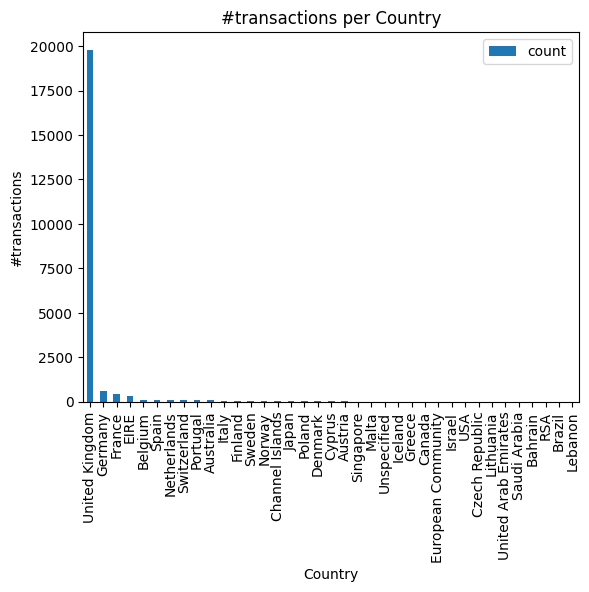

In [75]:
invoice_counts = df_spark_filtered.groupBy(['Country', 'InvoiceNo']).count().groupBy('Country').count().orderBy('count', ascending=False)
#print sum of invoice_counts
print(f"Sum of invoice counts: {invoice_counts.agg({'count': 'sum'}).collect()[0][0]}")
pandas_df = invoice_counts.toPandas()
pandas_df.plot(kind="bar", x="Country", y="count")
plt.title("#transactions per Country")
plt.xlabel("Country")
plt.ylabel("#transactions")
plt.show()

Sum of cancelled invoice counts: 3601


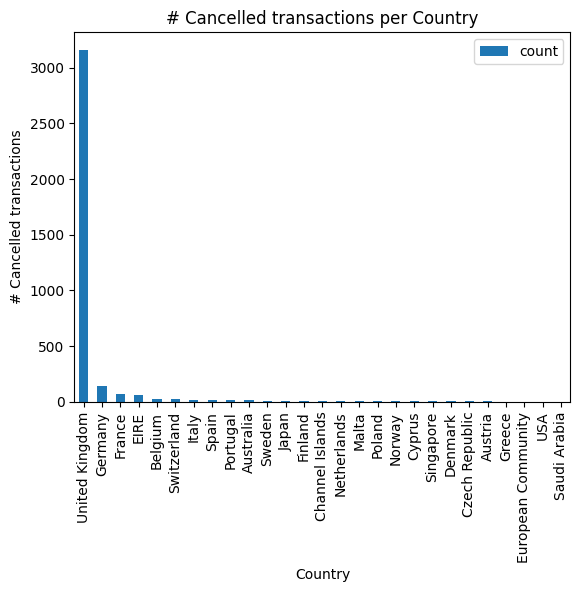

In [76]:
cancelled_invoice_counts = df_spark_filtered.filter(df_spark_filtered['InvoiceNo'].contains('C')).groupBy(['Country', 'InvoiceNo']).count().groupBy('Country').count().orderBy('count', ascending=False)
print(f"Sum of cancelled invoice counts: {cancelled_invoice_counts.agg({'count': 'sum'}).collect()[0][0]}")
pandas_df = cancelled_invoice_counts.toPandas()
pandas_df.plot(kind="bar", x="Country", y="count")
plt.title("# Cancelled transactions per Country")
plt.xlabel("Country")
plt.ylabel("# Cancelled transactions")
plt.show()

In [77]:
df_initial=df_spark_filtered.toPandas()
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

In [80]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

# Feature Engineering

* Recency - How recently did this customer make his/her last
purchase?
* Frequency - How often did this customer make purchases?
* Monetary value - How much did this customer spend?

In [14]:
# Define a function to compute the total cost for each basket
def calculate_basket_total(row):
    customer_id, invoice_no, quantity, unit_price = row
    total_cost = quantity * unit_price
    return ((customer_id, invoice_no), total_cost)

# Map the input DataFrame to (key, value) pairs, where the key is a tuple of (CustomerID, InvoiceNo) and the value is the TotalCost
rdd = df_spark_filtered.rdd.map(lambda row: calculate_basket_total((row['CustomerID'], row['InvoiceNo'], row['Quantity'], row['UnitPrice'])))

# Reduce the RDD by key (i.e., CustomerID and InvoiceNo), summing the TotalCost for each basket
basket_rdd = rdd.reduceByKey(lambda a, b: a + b)

# Convert the resulting RDD of (key, value) pairs to a DataFrame, and rename the TotalCost column
basket_price = basket_rdd.map(lambda row: (row[0][0], row[0][1], row[1])).toDF(['CustomerID', 'InvoiceNo', 'TotalCost'])

# Sort the DataFrame by CustomerID
basket_price = basket_price.sort('CustomerID')

# Show the contents of the new DataFrame
show_df( basket_price)

+----------+---------+------------------+
|CustomerID|InvoiceNo|         TotalCost|
+----------+---------+------------------+
|   12346.0|   541431|           77183.6|
|   12346.0|  C541433|          -77183.6|
|   12347.0|   562032|            584.91|
|   12347.0|   549222|            636.25|
|   12347.0|   581180|224.82000000000002|
+----------+---------+------------------+
only showing top 5 rows



In [15]:
# stats of total cost in basket price
df_stats(basket_price.select('TotalCost'))

+-------+------------------+
|summary|         TotalCost|
+-------+------------------+
|  count|             22190|
|   mean| 374.0453273546637|
| stddev|2018.4828692316019|
|    min|         -168469.6|
|    max|          168469.6|
+-------+------------------+



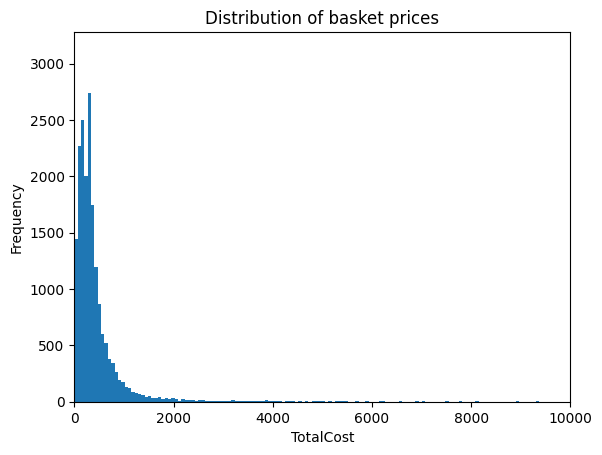

In [16]:
values_distribution(basket_price,'TotalCost',bins=5000,xlim=10000,xlabel='TotalCost',ylabel='Frequency',title='Distribution of basket prices')

In [17]:
# Define a function to compute the sum and count for each customer
def calculate_customer_stats(row):
    customer_id, total_cost = row
    return (customer_id, (total_cost, 1))

# Map the basket_price DataFrame to (key, value) pairs, where the key is the CustomerID and the value is a tuple containing the TotalCost and a count of 1
rdd = basket_price.rdd.map(lambda row: (row['CustomerID'], row['TotalCost'])).map(calculate_customer_stats)

# Reduce the RDD by key (i.e., CustomerID), summing the TotalCost and count for each customer
customer_rdd = rdd.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# Map the resulting RDD of (key, value) pairs to (key, value) pairs where the key is the CustomerID and the value is the average purchase value
avg_purchase_value_rdd = customer_rdd.map(lambda row: (row[0], row[1][0] / row[1][1]))

# Convert the resulting RDD of (key, value) pairs to a DataFrame, and rename the column
avg_purchase_value = avg_purchase_value_rdd.toDF(['CustomerID', 'AvgPurchaseValue'])

# Show the contents of the new DataFrame
show_df(avg_purchase_value)

+----------+------------------+
|CustomerID|  AvgPurchaseValue|
+----------+------------------+
|   12346.0|               0.0|
|   12347.0| 615.7142857142857|
|   12348.0|449.31000000000006|
|   12349.0|           1757.55|
|   12350.0|334.40000000000003|
+----------+------------------+
only showing top 5 rows



In [18]:
df_stats(avg_purchase_value.select('AvgPurchaseValue'))

+-------+------------------+
|summary|  AvgPurchaseValue|
+-------+------------------+
|  count|              4372|
|   mean|315.88340742424185|
| stddev| 361.2373033626041|
|    min|          -4287.63|
|    max| 6207.669999999996|
+-------+------------------+



In [19]:
avg_purchase_value.filter(avg_purchase_value['AvgPurchaseValue'] < 0).count()
customers_with_neg_avg_purchase_value = avg_purchase_value.filter(avg_purchase_value['AvgPurchaseValue'] < 0).select('CustomerID','AvgPurchaseValue').collect()

# remove the customers with negative avg purchase value from df_spark_filtered
print("transactions before removing customers with negative avg purchase value: ", df_spark_filtered.count())
df_spark_filtered = df_spark_filtered.filter(~df_spark_filtered['CustomerID'].isin([x['CustomerID'] for x in customers_with_neg_avg_purchase_value]))
print("transactions after removing customers with negative avg purchase value: ", df_spark_filtered.count())


transactions before removing customers with negative avg purchase value:  406829
transactions after removing customers with negative avg purchase value:  406431


In [20]:
avg_purchase_value = avg_purchase_value.filter(~avg_purchase_value['CustomerID'].isin([x['CustomerID'] for x in customers_with_neg_avg_purchase_value]))
basket_price = basket_price.filter(~basket_price['CustomerID'].isin([x['CustomerID'] for x in customers_with_neg_avg_purchase_value]))

In [21]:
df_stats(avg_purchase_value.select('AvgPurchaseValue'))

+-------+------------------+
|summary|  AvgPurchaseValue|
+-------+------------------+
|  count|              4330|
|   mean|321.55568681881095|
| stddev|351.36404226039366|
|    min|               0.0|
|    max| 6207.669999999996|
+-------+------------------+



In [22]:
# stats of total cost in basket price
df_stats(basket_price.select('TotalCost'))

+-------+------------------+
|summary|         TotalCost|
+-------+------------------+
|  count|             22125|
|   mean|375.74214481355875|
| stddev|  2020.86601904734|
|    min|         -168469.6|
|    max|          168469.6|
+-------+------------------+



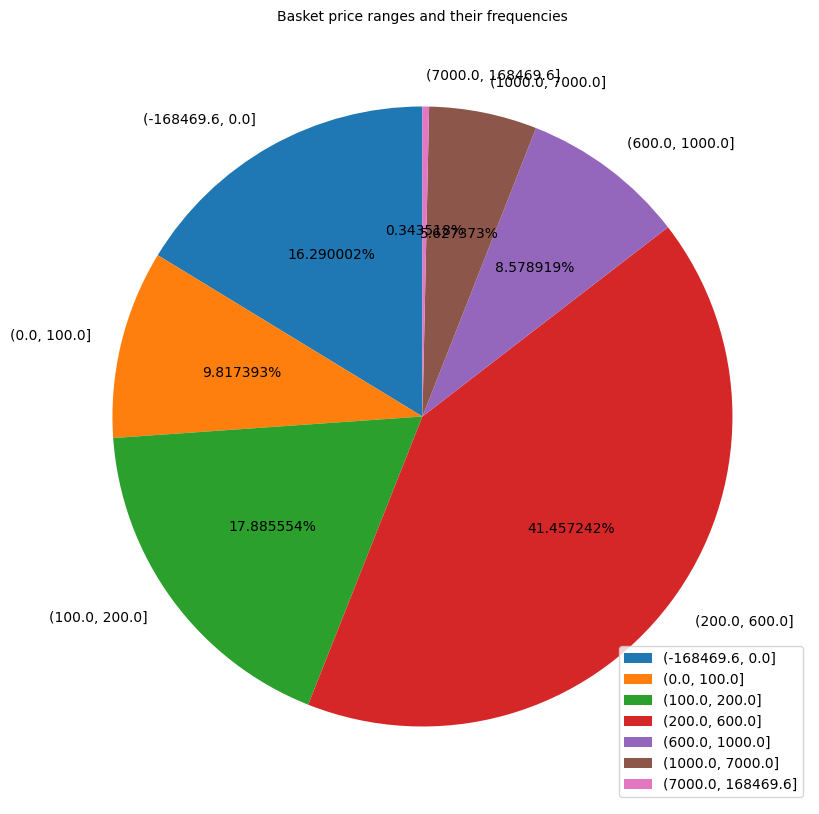

In [23]:
# construct ranges for the basket prices and count the number of baskets in each range
ranges = [-168469.6,0, 100, 200, 600, 1000, 7000,168469.6]
basket_price_pd = basket_price.toPandas()
basket_price_range = basket_price_pd.groupby(pd.cut(basket_price_pd['TotalCost'], ranges)).count()
basket_price_range

# plot pie chart of the basket ranges and their frequencies
ax, fig = plt.subplots(figsize=(10,15))
# plot pie chart
plt.pie(basket_price_range['TotalCost'], labels=basket_price_range.index, autopct='%1f%%', startangle=90)
# title
plt.title('Basket price ranges and their frequencies', fontsize=10)
# legend
plt.legend(basket_price_range.index, loc='lower right', fontsize=10)
plt.show()


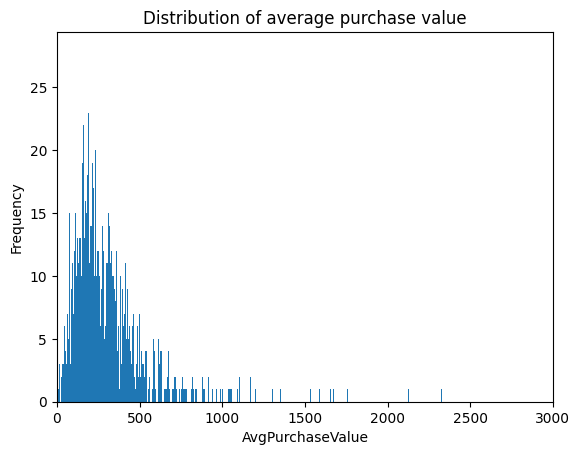

In [24]:
values_distribution(avg_purchase_value,col='AvgPurchaseValue',bins=5000,xlim=3000,xlabel='AvgPurchaseValue',title='Distribution of average purchase value')

In [25]:
# Map the basket_price DataFrame to (key, value) pairs, where the key is the CustomerID and the value is 1
rdd = basket_price.rdd.map(lambda row: (row['CustomerID'], 1))

# Reduce the RDD by key (i.e., CustomerID), summing the counts for each customer
customer_rdd = rdd.reduceByKey(lambda a, b: a + b)

# Convert the resulting RDD of (key, value) pairs to a DataFrame, and rename the column
frequency_of_purchases = customer_rdd.toDF(['CustomerID', 'FrequencyOfPurchases'])

# Show the contents of the new DataFrame
show_df(frequency_of_purchases)

+----------+--------------------+
|CustomerID|FrequencyOfPurchases|
+----------+--------------------+
|   12346.0|                   2|
|   12347.0|                   7|
|   12348.0|                   4|
|   12349.0|                   1|
|   12350.0|                   1|
+----------+--------------------+
only showing top 5 rows



In [26]:
df_stats(frequency_of_purchases.select('FrequencyOfPurchases'))

+-------+--------------------+
|summary|FrequencyOfPurchases|
+-------+--------------------+
|  count|                4330|
|   mean|   5.109699769053118|
| stddev|   9.376827828095204|
|    min|                   1|
|    max|                 248|
+-------+--------------------+



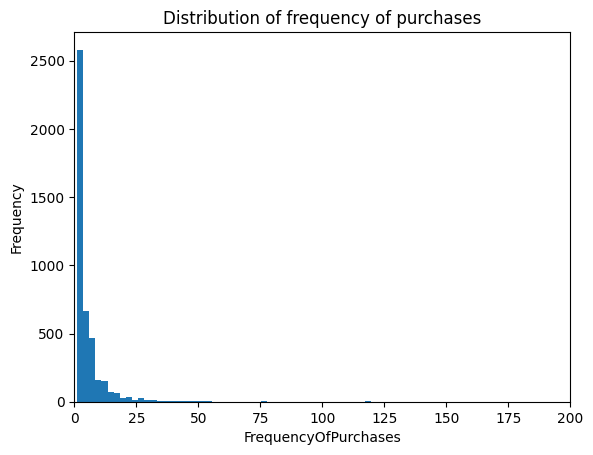

In [27]:
values_distribution(frequency_of_purchases,col='FrequencyOfPurchases',bins=100,xlim=200,xlabel='FrequencyOfPurchases',title='Distribution of frequency of purchases')

In [28]:
from pyspark.sql.functions import min as min_builtin
from pyspark.sql.functions import max as max_builtin
from builtins import min,max
# convert InvoiceDate column to date
df_spark_filtered = df_spark_filtered.withColumn('InvoiceDate', to_date(df_spark_filtered['InvoiceDate']))

# calculate the difference between the last and the first purchase
window = Window.partitionBy('CustomerID').orderBy('InvoiceDate')
df_spark_filtered = df_spark_filtered.withColumn('FirstPurchase', min_builtin('InvoiceDate').over(window))
df_spark_filtered = df_spark_filtered.withColumn('LastPurchase', max_builtin('InvoiceDate').over(window))

# Map the df_spark_filtered DataFrame to (key, value) pairs, where the key is the CustomerID and the value is a tuple containing the InvoiceDate, FirstPurchase, and LastPurchase
rdd = df_spark_filtered.rdd.map(lambda row: (row['CustomerID'], (row['InvoiceDate'], row['FirstPurchase'], row['LastPurchase'])))

# Reduce the RDD by key (i.e., CustomerID), finding the minimum and maximum InvoiceDate for each customer
customer_rdd = rdd.reduceByKey(lambda a, b: (min(a[0], b[0]), min(a[1], b[1]), max(a[2], b[2])))


# Map the resulting RDD of (key, value) pairs to (key, value) pairs where the key is the CustomerID and the value is the difference in days between the LastPurchase and FirstPurchase
customer_lifetime_value_rdd = customer_rdd.map(lambda row: (row[0], (row[1][2] - row[1][1]).days))

# Convert the resulting RDD of (key, value) pairs to a DataFrame, and rename the column
customer_lifetime_value = customer_lifetime_value_rdd.toDF(['CustomerID', 'CustomerLifetimeValue'])

# Show the contents of the new DataFrame
customer_lifetime_value.show()

+----------+---------------------+
|CustomerID|CustomerLifetimeValue|
+----------+---------------------+
|   12356.0|                  303|
|   12364.0|                  105|
|   12380.0|                  164|
|   12408.0|                  228|
|   12424.0|                    0|
|   12484.0|                  304|
|   12488.0|                   66|
|   12500.0|                  310|
|   12536.0|                   52|
|   12600.0|                  343|
|   12616.0|                  212|
|   12624.0|                   71|
|   12640.0|                   58|
|   12648.0|                    0|
|   12668.0|                  348|
|   12700.0|                  208|
|   12836.0|                  252|
|   12856.0|                   56|
|   12912.0|                   38|
|   12920.0|                    0|
+----------+---------------------+
only showing top 20 rows



In [29]:
df_stats(customer_lifetime_value.select('CustomerLifetimeValue'))

+-------+---------------------+
|summary|CustomerLifetimeValue|
+-------+---------------------+
|  count|                 4330|
|   mean|   134.68198614318706|
| stddev|   133.05067847782422|
|    min|                    0|
|    max|                  373|
+-------+---------------------+



In [30]:
# Convert the DataFrame to an RDD
rdd = df_spark_filtered.rdd

# Map the RDD to (key, value) pairs, where the key is a tuple of (CustomerID, InvoiceNo) and the value is the Quantity
rdd_keyed = rdd.map(lambda row: ((row['CustomerID'], row['InvoiceNo']), row['Quantity']))

# Reduce the RDD by key, summing the Quantities for each unique (CustomerID, InvoiceNo) pair
rdd_reduced = rdd_keyed.reduceByKey(lambda a, b: a + b)

# Map the resulting RDD of (key, value) pairs to a new RDD of (CustomerID, InvoiceNo, BasketSize) tuples
rdd_output = rdd_reduced.map(lambda row: (row[0][0], row[0][1], row[1]))

# Convert the resulting RDD to a DataFrame
basket_size = rdd_output.toDF(['CustomerID', 'InvoiceNo', 'BasketSize'])

# Show the contents of the new DataFrame
basket_size.show()

+----------+---------+----------+
|CustomerID|InvoiceNo|BasketSize|
+----------+---------+----------+
|   12356.0|   549435|       370|
|   12359.0|  C549955|        -4|
|   12359.0|   571034|       657|
|   12365.0|  C544577|        -1|
|   12379.0|  C559193|        -1|
|   12379.0|   567196|       196|
|   12381.0|   563100|       568|
|   12381.0|   574694|       146|
|   12383.0|   540971|       590|
|   12383.0|  C541586|        -3|
|   12390.0|   567530|       353|
|   12394.0|   552188|       182|
|   12401.0|   543537|        11|
|   12408.0|   547685|        26|
|   12408.0|   574862|       365|
|   12408.0|  C574865|        -1|
|   12414.0|   543027|       145|
|   12421.0|   557297|       145|
|   12421.0|   578339|        77|
|   12424.0|   558537|       208|
+----------+---------+----------+
only showing top 20 rows



In [31]:
df_stats(basket_size.select('BasketSize'))

+-------+------------------+
|summary|        BasketSize|
+-------+------------------+
|  count|             22125|
|   mean| 221.8508474576271|
| stddev|1171.7778905485325|
|    min|            -80995|
|    max|             80995|
+-------+------------------+



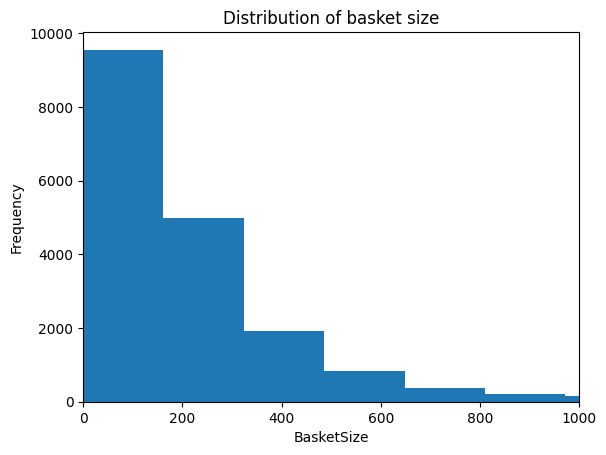

In [32]:
values_distribution(basket_size,'BasketSize',bins=1000,xlim=1000,title='Distribution of basket size',xlabel='BasketSize')

In [33]:
def averaging(df,group_col,summary_col,new_col):
  rdd = df.rdd

  # Map the RDD to (key, value) pairs, where the key is the group_col and the value is the summary_col
  rdd_keyed = rdd.map(lambda row: (row[group_col], row[summary_col]))

  # Reduce the RDD by key, computing the sum and count of summary_col for each group_col
  rdd_reduced = rdd_keyed.aggregateByKey((0.0, 0), lambda acc, val: (acc[0] + val, acc[1] + 1), lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1]))

  # Map the resulting RDD of (key, value) pairs to a new RDD of (group_col, new_col) tuples
  rdd_output = rdd_reduced.map(lambda row: (row[0], row[1][0] / row[1][1]))

  # Convert the resulting RDD to a DataFrame
  output = rdd_output.toDF([group_col, new_col])
  return output

In [34]:
avg_basket_price = averaging(basket_price,'CustomerID','TotalCost','AvgBasketPrice')
show_df(avg_basket_price)

+----------+------------------+
|CustomerID|    AvgBasketPrice|
+----------+------------------+
|   12346.0|               0.0|
|   12347.0| 615.7142857142857|
|   12348.0|449.31000000000006|
|   12349.0|           1757.55|
|   12350.0|334.40000000000003|
+----------+------------------+
only showing top 5 rows



In [35]:
avg_basket_size = averaging(basket_size,'CustomerID','BasketSize','AvgBasketSize')
show_df(avg_basket_size)

+----------+------------------+
|CustomerID|     AvgBasketSize|
+----------+------------------+
|   12356.0| 530.3333333333334|
|   12408.0|155.44444444444446|
|   12424.0|             370.0|
|   12484.0|           273.125|
|   12488.0|176.33333333333334|
+----------+------------------+
only showing top 5 rows



In [36]:
# print shapes of the DataFrames
print("avg_basket_price: ", (avg_basket_price.count(), len(avg_basket_price.columns)))
print("frequency_of_purchases: ", (frequency_of_purchases.count(), len(frequency_of_purchases.columns)))
print("basket_size: ", (avg_basket_size.count(), len(avg_basket_size.columns)))
print("customer_lifetime_value: ", (customer_lifetime_value.count(), len(customer_lifetime_value.columns)))

avg_basket_price:  (4330, 2)
frequency_of_purchases:  (4330, 2)
basket_size:  (4330, 2)
customer_lifetime_value:  (4330, 2)


In [37]:
dfs = [avg_basket_price, frequency_of_purchases, avg_basket_size, customer_lifetime_value]

df_final = reduce(lambda left, right: left.join(right, on='CustomerID', how='outer'), dfs)

show_df(df_final)

+----------+------------------+--------------------+------------------+---------------------+
|CustomerID|    AvgBasketPrice|FrequencyOfPurchases|     AvgBasketSize|CustomerLifetimeValue|
+----------+------------------+--------------------+------------------+---------------------+
|   12346.0|               0.0|                   2|               0.0|                    0|
|   12347.0| 615.7142857142857|                   7|351.14285714285717|                  365|
|   12348.0|449.31000000000006|                   4|            585.25|                  283|
|   12349.0|           1757.55|                   1|             631.0|                    0|
|   12350.0|334.40000000000003|                   1|             197.0|                    0|
+----------+------------------+--------------------+------------------+---------------------+
only showing top 5 rows



In [38]:
df_stats(df_final)

+-------+------------------+------------------+--------------------+------------------+---------------------+
|summary|        CustomerID|    AvgBasketPrice|FrequencyOfPurchases|     AvgBasketSize|CustomerLifetimeValue|
+-------+------------------+------------------+--------------------+------------------+---------------------+
|  count|              4330|              4330|                4330|              4330|                 4330|
|   mean|15299.291916859122|321.55568681881095|   5.109699769053118|198.97555181436482|   134.68198614318706|
| stddev|1722.0418499064176|351.36404226039366|   9.376827828095204| 321.8904511396367|   133.05067847782433|
|    min|           12346.0|               0.0|                   1|             -94.5|                    0|
|    max|           18287.0| 6207.669999999996|                 248|           12540.0|                  373|
+-------+------------------+------------------+--------------------+------------------+---------------------+



In [39]:
from pyspark.sql.functions import count, when
from operator import add

# Map function to emit (customer_id, (is_return, 1)) key-value pairs
def map_func(row):
    customer_id = row['CustomerID']
    invoice_no = row['InvoiceNo']
    is_return = 1 if invoice_no.startswith('C') else 0
    return (customer_id, (is_return, 1))

# Reduce function to aggregate the (is_return, count) values for each customer
def reduce_func(x, y):
    return (x[0] + y[0], x[1] + y[1])

# Apply map function to dataset and reduce by key to get (customer_id, (total_returns, total_transactions)) pairs
customer_returns = df_spark_filtered.select('CustomerID', 'InvoiceNo').distinct().rdd.map(map_func).reduceByKey(reduce_func)
# Calculate product returns for each customer using map function
product_returns = customer_returns.map(lambda x: (x[0], x[1][0] / x[1][1] if x[1][1] > 0 else 0))

# Collect the results as a list of tuples and convert to a PySpark DataFrame
product_returns = spark.createDataFrame(product_returns.collect(), ['CustomerID', 'ProductReturns'])
product_returns.sample(False, 0.001).show()


+----------+-------------------+
|CustomerID|     ProductReturns|
+----------+-------------------+
|   15159.0|0.11764705882352941|
|   12471.0| 0.3877551020408163|
|   15508.0|                0.0|
|   12560.0|               0.25|
|   13272.0|                0.0|
+----------+-------------------+



In [40]:
df_spark_filtered.filter(df_spark_filtered['CustomerID'] == 14792.0).select('InvoiceNo').distinct().show()


+---------+
|InvoiceNo|
+---------+
|   570003|
|  C569954|
+---------+



In [41]:
from pyspark.sql.functions import countDistinct, mean

basket_diversity = (df_spark_filtered
                   .groupBy("CustomerID", "InvoiceNo")
                   .agg(countDistinct("StockCode").alias("unique_stock_count"))
                   .groupBy("CustomerID")
                   .agg(mean("unique_stock_count").alias("basket_diversity"))
                   .select("CustomerID", "basket_diversity"))
basket_diversity.sample(False, 0.001).show()


+----------+----------------+
|CustomerID|basket_diversity|
+----------+----------------+
|   13647.0|            15.8|
|   13832.0|             2.0|
|   16984.0|            78.6|
|   13692.0|            11.0|
|   14005.0|            16.8|
|   14618.0|             4.0|
+----------+----------------+



In [42]:
#get customerID, InvoiceNo, and StockCode
cust=df_spark_filtered.filter(df_spark_filtered['CustomerID'] == 17314.0).distinct().select('CustomerID', 'InvoiceNo', 'StockCode')
#then count number of unique StockCode for each InvoiceNo
cust=cust.groupBy('CustomerID', 'InvoiceNo').agg(countDistinct('StockCode').alias('unique_stock_count'))
cust.show()
#then calculate the mean of unique_stock_count
cust=cust.groupBy('CustomerID').agg(mean('unique_stock_count').alias('basket_diversity'))
cust.show()

+----------+---------+------------------+
|CustomerID|InvoiceNo|unique_stock_count|
+----------+---------+------------------+
|   17314.0|   542641|                 5|
|   17314.0|  C544829|                 2|
|   17314.0|   547885|                 7|
|   17314.0|   557898|                24|
|   17314.0|   575911|                17|
|   17314.0|   576385|                 1|
|   17314.0|   559980|                 8|
|   17314.0|   542786|                21|
|   17314.0|  C548307|                 1|
|   17314.0|  C572482|                 2|
|   17314.0|   570855|                48|
+----------+---------+------------------+

+----------+------------------+
|CustomerID|  basket_diversity|
+----------+------------------+
|   17314.0|12.363636363636363|
+----------+------------------+



In [43]:
from pyspark.sql.functions import quarter

#make column that contains the number of unique transactions in quarter1 for each customer
quarter1 = df_spark_filtered.filter(quarter(df_spark_filtered['InvoiceDate']) == 1)
quarter1 = quarter1.groupBy('CustomerID').agg(countDistinct('InvoiceNo').alias('unique_transactions_q1'))
quarter2=df_spark_filtered.filter(quarter(df_spark_filtered['InvoiceDate']) == 2)
quarter2 = quarter2.groupBy('CustomerID').agg(countDistinct('InvoiceNo').alias('unique_transactions_q2'))
quarter3=df_spark_filtered.filter(quarter(df_spark_filtered['InvoiceDate']) == 3)
quarter3 = quarter3.groupBy('CustomerID').agg(countDistinct('InvoiceNo').alias('unique_transactions_q3'))
quarter4=df_spark_filtered.filter(quarter(df_spark_filtered['InvoiceDate']) == 4)
quarter4 = quarter4.groupBy('CustomerID').agg(countDistinct('InvoiceNo').alias('unique_transactions_q4'))

quarters = quarter1.join(quarter2, 'CustomerID', 'outer')
quarters = quarters.join(quarter3, 'CustomerID', 'outer')
quarters = quarters.join(quarter4, 'CustomerID', 'outer')
#any null values are replaced with 0
quarters = quarters.na.fill(0)

In [44]:
copy_filtered = df_spark_filtered.select('*')
print(copy_filtered.count())
copy_filtered=copy_filtered.join(quarters, 'CustomerID', 'outer')
copy_filtered=copy_filtered.join(basket_diversity, 'CustomerID', 'outer')
copy_filtered=copy_filtered.join(product_returns, 'CustomerID', 'outer')


406431


In [45]:
features = copy_filtered.dropDuplicates(['CustomerID'])
# Show the unique rows
print("len:  ",features.count())

len:   4330


In [46]:
features = features.select(['CustomerID','unique_transactions_q1','unique_transactions_q2','unique_transactions_q3','unique_transactions_q4','basket_diversity','ProductReturns'])
df_final =df_final.join(features,'CustomerID','left') 

In [47]:
# create a VectorAssembler object
assembler = VectorAssembler(inputCols=['AvgBasketPrice', 'FrequencyOfPurchases', 'AvgBasketSize', 'CustomerLifetimeValue','unique_transactions_q1','unique_transactions_q2','unique_transactions_q3','unique_transactions_q4','basket_diversity','ProductReturns'
                                       ], outputCol='features')

# transform the DataFrame
df_final = assembler.transform(df_final)


# create a StandardScaler object
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)

# fit the DataFrame to the scaler
scalerModel = scaler.fit(df_final)

# transform the DataFrame
df_assembled = scalerModel.transform(df_final)

# print the first row of the scaled DataFrame
show_df(df_assembled)


+----------+------------------+--------------------+-----------------+---------------------+----------------------+----------------------+----------------------+----------------------+------------------+------------------+--------------------+--------------------+
|CustomerID|    AvgBasketPrice|FrequencyOfPurchases|    AvgBasketSize|CustomerLifetimeValue|unique_transactions_q1|unique_transactions_q2|unique_transactions_q3|unique_transactions_q4|  basket_diversity|    ProductReturns|            features|      scaledFeatures|
+----------+------------------+--------------------+-----------------+---------------------+----------------------+----------------------+----------------------+----------------------+------------------+------------------+--------------------+--------------------+
|   12493.0|            138.93|                   3|68.66666666666667|                   32|                     0|                     3|                     0|                     0| 7.666666666666667|0.

# K-means Clustering

In [83]:
scaled_features_pd = df_assembled.select('scaledFeatures')

# apply K-means clustering
from pyspark.ml.clustering import KMeans

# create an instance of the K-means algorithm

# kmeans = KMeans(featuresCol='scaledFeatures', k=5, distanceMeasure='cosine')
kmeans = KMeans(featuresCol='features', k=7)
# train the model
model = kmeans.fit(df_assembled)

# make predictions
predictions = model.transform(df_assembled)

# print the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")

for center in centers:
    print(center)

Cluster Centers: 
[1.57921791e+02 4.02049911e+00 8.92450803e+01 1.08768717e+02
 7.33957219e-01 8.83689840e-01 8.85918004e-01 1.51693405e+00
 1.38494605e+01 1.20026990e-01]
[3.62519035e+03 1.76250000e+01 1.15949565e+03 1.55875000e+02
 1.75000000e+00 3.50000000e+00 6.12500000e+00 6.25000000e+00
 1.65938713e+01 7.50820416e-02]
[1.50598002e+03 8.17105263e+00 1.00380663e+03 1.47644737e+02
 1.61842105e+00 1.63157895e+00 2.28947368e+00 2.63157895e+00
 3.14548861e+01 8.26942380e-02]
[7.19370159e+02 4.65569620e+00 4.68263204e+02 1.17174684e+02
 8.25316456e-01 1.01012658e+00 1.16202532e+00 1.65822785e+00
 3.43734867e+01 6.63905393e-02]
[3.55708041e+02 6.50814536e+00 2.15237347e+02 1.75176065e+02
 1.19611529e+00 1.48809524e+00 1.56954887e+00 2.25438596e+00
 2.26320863e+01 9.50761618e-02]
[0.000e+00 1.000e+00 1.254e+04 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00]
[4.26423737e+03 1.14000000e+01 3.47101384e+03 7.63000000e+01
 2.00000000e+00 2.70000000e+00 2.80000000e+00 3.

In [84]:

# evaluate the model
from pyspark.ml.evaluation import ClusteringEvaluator

# create an instance of the evaluator
evaluator = ClusteringEvaluator()
 
# calculate the silhouette score
#s(i) = (b(i) - a(i)) / max(a(i), b(i))
#a(i) is the average distance between i and all other points in its cluster
#b(i) is the smallest average distance between i and all points in any other cluster.
#A score of 1 means that the data point fits well into its assigned cluster and poorly into other clusters.
#A score of 0 means that the data point is on the boundary between two clusters.
#A score of -1 means that the data point fits poorly into its assigned cluster and well into other clusters.
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


Silhouette with squared euclidean distance = 0.46153339995902604


In [85]:
# Distribution of the clusters
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|    8|
|         6|   10|
|         3|  399|
|         5|    1|
|         4| 1604|
|         2|   76|
|         0| 2232|
+----------+-----+



In [86]:
predictions_pd = predictions.select('scaledFeatures').toPandas()

# number of variables
categories = ['AvgBasketPrice', 'FrequencyOfPurchases', 'AvgBasketSize', 'CustomerLifetimeValue','unique_transactions_q1','unique_transactions_q2','unique_transactions_q3','unique_transactions_q4','basket_diversity','ProductReturns']
# create a list to store the radar charts
charts = []

# create a radar chart for each cluster and add it to the list
for i in range(len(centers)):
    values = predictions_pd.loc[i, 'scaledFeatures'].toArray().flatten().tolist()
    chart = pygal.Radar(fill=True)
    chart.title = 'Cluster %d' % (i + 1)
    chart.x_labels = categories
    chart.add('Cluster %d' % (i + 1), [x for x in values], fill_color='red')
    chart.show_legend = True
    charts.append(chart)

# create a combined radar chart from the list of charts
combined_chart = pygal.StackedLine(fill=True, interpolate='cubic', style=pygal.style.LightStyle)
combined_chart.title = 'Cluster Analysis'
combined_chart.x_labels = categories
for i in range(len(centers)):
    values = predictions_pd.loc[i, 'scaledFeatures'].toArray().flatten().tolist() 
    combined_chart.add('Cluster %d' % (i + 1), [x for x in values])
combined_chart.render_to_file('cluster_analysis.svg')
    

# BisectingKMeans

In [52]:
from pyspark.ml.clustering import BisectingKMeans

# create an instance of the BisectingKMeans algorithm
bisecting_kmeans = BisectingKMeans(featuresCol='features', k=10)

# train the model
model = bisecting_kmeans.fit(df_assembled)

# make predictions
predictions = model.transform(df_assembled)

# print the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")

for center in centers:
    print(center)

Cluster Centers: 
[1.32412054e+02 2.20136519e+00 7.31918658e+01 3.33634812e+01
 3.41296928e-01 4.65017065e-01 4.96587031e-01 8.98464164e-01
 1.19995613e+01 1.13804026e-01]
[2.94235044e+02 1.95342820e+00 1.77172887e+02 2.72341527e+01
 2.36739974e-01 3.10478655e-01 5.29107374e-01 8.77102199e-01
 2.15834173e+01 5.78709992e-02]
[1.62477486e+02 8.45914397e+00 8.80238228e+01 2.77857328e+02
 1.74967575e+00 1.92996109e+00 1.77561608e+00 3.00389105e+00
 1.42714696e+01 1.57949506e-01]
[3.03350884e+02 8.99244713e+00 1.89063065e+02 2.74545317e+02
 1.66767372e+00 2.16012085e+00 2.15105740e+00 3.01359517e+00
 2.00951794e+01 1.28410267e-01]
[4.94088280e+02 5.73600000e+00 3.01787262e+02 1.34910400e+02
 1.06560000e+00 1.30560000e+00 1.41440000e+00 1.95040000e+00
 2.73617573e+01 7.38891422e-02]
[8.17913348e+02 4.69361702e+00 5.38266248e+02 1.26012766e+02
 7.74468085e-01 1.01276596e+00 1.21702128e+00 1.68936170e+00
 3.79516968e+01 7.11761758e-02]
[1.48895857e+03 8.67142857e+00 9.80200058e+02 1.51214286e+

In [53]:

# evaluate the model
from pyspark.ml.evaluation import ClusteringEvaluator

# create an instance of the evaluator
evaluator = ClusteringEvaluator()
 
# calculate the silhouette score
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


Silhouette with squared euclidean distance = 0.4573971549358115


In [54]:
# Distribution of the clusters
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  773|
|         6|   70|
|         3|  662|
|         5|  235|
|         9|   10|
|         4|  625|
|         8|    2|
|         7|   10|
|         2|  771|
|         0| 1172|
+----------+-----+



In [55]:
predictions_pd = predictions.select('scaledFeatures').toPandas()

# number of variables
categories = ['AvgBasketPrice', 'FrequencyOfPurchases', 'AvgBasketSize', 'CustomerLifetimeValue','unique_transactions_q1','unique_transactions_q2','unique_transactions_q3','unique_transactions_q4','basket_diversity','ProductReturns']
# create a list to store the radar charts
charts = []

# create a radar chart for each cluster and add it to the list
for i in range(len(centers)):
    values = predictions_pd.loc[i, 'scaledFeatures'].toArray().flatten().tolist()
    chart = pygal.Radar(fill=True)
    chart.title = 'Cluster %d' % (i + 1)
    chart.x_labels = categories
    chart.add('Cluster %d' % (i + 1), [x for x in values], fill_color='red')
    chart.show_legend = True
    charts.append(chart)

# create a combined radar chart from the list of charts
combined_chart = pygal.StackedLine(fill=True, interpolate='cubic', style=pygal.style.LightStyle)
combined_chart.title = 'Cluster Analysis'
combined_chart.x_labels = categories
for i in range(len(centers)):
    values = predictions_pd.loc[i, 'scaledFeatures'].toArray().flatten().tolist() 
    combined_chart.add('Cluster %d' % (i + 1), [x for x in values])
combined_chart.render_to_file('hei_cluster_analysis.svg')
    